## 2) 양방향 LSTM을 이용한 품사 태깅(Part-of-speech Tagging using Bi-LSTM)

품사 태깅에 대해서는 이미 2챕터의 토큰화 챕터에서 배운 바 있다. 그 당시에는 NLTK와 KoNLPy를 이용해서 이미 기존에 있는 모델로 품사 태깅을 수행하였지만, 여기서는 직접 양방향 LSTM을 이용한 품사 태깅을 수행하는 모델을 만들어보도록 한다.



### 1.품사 태깅 데이터에 대한 이해와 전처리

이번에는 양방향 LSTM을 사용해서 품사 태깅을 하는 모델을 만들어보겠다.


In [ ]:
import nltk
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use(['seaborn-white'])
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

NLTK를 이용하면 영어 코퍼스에 토큰화와 품사 태깅 전처리를 진행한 문장 데이터를 받아올 수 있다. 여기서는 해당 데이터를 훈련시켜 품사 태깅을 수행하는 모델을 만들어보겠다. 우선 전체 문장 샘플의 개수를 확인한다.


In [ ]:
nltk.download('treebank')

tagged_sentences = nltk.corpus.treebank.tagged_sents() # 토큰화에 품사 태깅이 된 데이터 받아오기
print('품사 태깅이 된 문장 개수 :', len(tagged_sentences)) # 문장 샘플의 개수 출력

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.
품사 태깅이 된 문장 개수 : 3914


이 중 첫번째 샘플만 출력해보겠다.


In [ ]:
print(tagged_sentences[0]) # 첫번째 샘플 출력

[('Pierre', 'NNP'), ('Vinken', 'NNP'), (',', ','), ('61', 'CD'), ('years', 'NNS'), ('old', 'JJ'), (',', ','), ('will', 'MD'), ('join', 'VB'), ('the', 'DT'), ('board', 'NN'), ('as', 'IN'), ('a', 'DT'), ('nonexecutive', 'JJ'), ('director', 'NN'), ('Nov.', 'NNP'), ('29', 'CD'), ('.', '.')]


품사 태깅 전처리가 수행된 첫번째 문장이 출력된 것을 볼 수 있다. 이러한 문장 샘플이 총 3,914개가 있다. 그런데 훈련을 시키려면 훈련 데이터에서 단어에 해당되는 부분과 품사 태깅 정보에 해당되는 부분을 분리시켜야 한다. 즉, [('Pierre', 'NNP'), ('Vinken', 'NNP')]와 같은 문장 샘플이 있다면 Pierre과 Vinken을 같이 저장하고, NNP와 NNP를 같이 저장할 필요가 있다.

이런 경우 파이썬 함수 중에서 zip() 함수가 유용한 역할을 한다. zip() 함수는 동일한 개수를 가지는 시퀀스 자료형에서 각 순서에 등장하는 원소들끼리 묶어주는 역할을 한다. (2챕터의 데이터의 분리 챕터 참고)



In [ ]:
sentences, pos_tags = [], []

for tagged_sentence in tagged_sentences: # 3,914개의 문장 샘플을 1개씩 불러온다.

    sentence, tag_info = zip(*tagged_sentence) # 각 샘플에서 단어들은 sentence에, 품사 태깅 정보들은 tag_info에 저장한다.

    sentences.append(list(sentence)) # 각 샘플에서 단어 정보만 저장한다.
    pos_tags.append(list(tag_info)) # 각 샘플에서 품사 태깅 정보만 저장한다.
    

각 문장 샘플에 대해서 단어는 sentences에, 태깅 정보는 pos_tags에 저장하였다. 임의로 첫번째 문장 샘플을 출력해보겠다.


In [ ]:
print(sentences[0])
print(pos_tags[0])

['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.']
['NNP', 'NNP', ',', 'CD', 'NNS', 'JJ', ',', 'MD', 'VB', 'DT', 'NN', 'IN', 'DT', 'JJ', 'NN', 'NNP', 'CD', '.']


첫번째 샘플에 대해서 단어에 대해서만 sentences[0]에, 또한 품사에 대해서만 pos_tags[0]에 저장된 것을 볼 수 있다. 뒤에서 보겠지만, sentences는 예측을 위한 X에 해당되며, pos_tags는 예측 대상인 y에 해당된다. 다른 샘플들에 대해서도 처리가 되었는지 확인하기 위해 임의로 아홉번째 샘플에 대해서도 확인해보겠다.



In [ ]:
print(sentences[8])
print(pos_tags[8])

['We', "'re", 'talking', 'about', 'years', 'ago', 'before', 'anyone', 'heard', 'of', 'asbestos', 'having', 'any', 'questionable', 'properties', '.']
['PRP', 'VBP', 'VBG', 'IN', 'NNS', 'IN', 'IN', 'NN', 'VBD', 'IN', 'NN', 'VBG', 'DT', 'JJ', 'NNS', '.']


단어에 대해서만 sentences[8]에, 또한 품사에 대해서만 pos_tags[8]에 저장된 것을 확인할 수 있다. 또한 첫번째 샘플과 길이가 다른 것을 볼 수 있다. 사실 3,914개의 문장 샘플의 길이는 전부 제각각이다. 전체 데이터의 길이 분포를 확인해보자.


샘플의 최대 길이 : 271
샘플의 평균 길이 : 25.722024


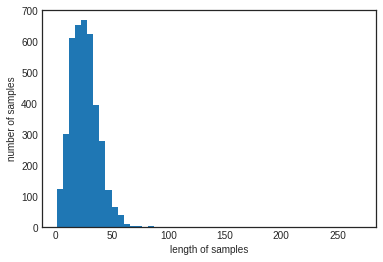

In [ ]:
print('샘플의 최대 길이 : %d' % max(len(l) for l in sentences))
print('샘플의 평균 길이 : %f' % (sum(map(len, sentences)) / len(sentences)))

plt.hist([len(s) for s in sentences], bins = 50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

위의 그래프는 대부분의 샘플의 길이가 150 이내이며, 대부분 0~50의 길이를 가지는 것을 보여준다. 이제 케라스 토크나이저를 통해서 정수 인코딩을 진행한다. 우선 케라스 토크나이저를 다음과 같이 함수로 구현한다.


In [ ]:
def tokenize(samples):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(samples)
    return tokenizer

문장 데이터에 대해서는 src_tokenizer를, 레이블에 해당되는 품사 태깅 정보에 대해서는 tar_tokenizer를 사용한다.


In [ ]:
src_tokenizer = tokenize(sentences)
tar_tokenizer = tokenize(pos_tags)

단어 집합과 품사 태깅 정보 집합의 크기를 확인해보겠다.


In [ ]:
vocab_size = len(src_tokenizer.word_index) + 1
tag_size = len(tar_tokenizer.word_index) + 1
print('단어 집합의 크기 : {}'.format(vocab_size))
print('태깅 정보 집합의 크기 : {}'.format(tag_size))


단어 집합의 크기 : 11388
태깅 정보 집합의 크기 : 47


이제 정수 인코딩을 수행한다.


In [ ]:
X_train = src_tokenizer.texts_to_sequences(sentences)
y_train = tar_tokenizer.texts_to_sequences(pos_tags)


이제 문장 데이터에 대해서 정수 인코딩이 수행된 결과는 X_train, 품사 태깅 데이터에 대해서 정수 인코딩이 수행된 결과는 y_train에 저장되었다. 정수 인코딩이 되었는지 확인을 위해 임의로 세번째 데이터를 출력해보겠다.


In [ ]:
print(X_train[:2])
print(y_train[:2])

[[5601, 3746, 1, 2024, 86, 331, 1, 46, 2405, 2, 131, 27, 6, 2025, 332, 459, 2026, 3], [31, 3746, 20, 177, 4, 5602, 2915, 1, 2, 2916, 637, 147, 3]]
[[3, 3, 8, 10, 6, 7, 8, 21, 13, 4, 1, 2, 4, 7, 1, 3, 10, 9], [3, 3, 17, 1, 2, 3, 3, 8, 4, 3, 19, 1, 9]]


앞서 본 그래프에 따르면, 대부분의 샘플은 길이가 150 이내이다. X에 해당되는 데이터 X_train의 샘플들과 y에 해당되는 데이터 y_train 샘플들의 모든 길이를 임의로 150 정도로 맞추어 보겠다. 이를 위해서 케라스의 pad_sequences()를 사용한다.


In [ ]:
max_len = 150
X_train = pad_sequences(X_train, maxlen = max_len, padding = 'post')
# X_train의 모든 샘플의 길이를 맞출 때 뒤의 공간에 숫자 0으로 채움.
y_train = pad_sequences(y_train, padding = 'post', maxlen = max_len)
# y_train의 모든 샘플의 길이를 맞출 때 뒤의 공간에 숫자 0으로 채움.

모든 샘플의 길이가 150이 되었다. 이제 훈련 데이터와 테스트 데이터를 8:2의 비율로 분리한다.


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2,
                                                    random_state = 777)

레이블에 해당하는 태깅 정보에 대해서 원-핫 인코딩을 수행한다.


In [ ]:
y_train = to_categorical(y_train, num_classes = tag_size)
y_test  = to_categorical(y_test , num_classes = tag_size)

이제 각 데이터에 대한 크기를 확인해보겠다.


In [ ]:
print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))

print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (3131, 150)
훈련 샘플 레이블의 크기 : (3131, 150, 47)
테스트 샘플 문장의 크기 : (783, 150)
테스트 샘플 레이블의 크기 : (783, 150, 47)


### 2.양방향 LSTM(Bi-directional LSTM)으로 POS Tagger 만들기


In [ ]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding
# from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding
from keras.optimizers import Adam

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 128, input_length = max_len, mask_zero = True))
model.add(Bidirectional(LSTM(256, return_sequences = True)))
model.add(TimeDistributed(Dense(tag_size, activation = 'softmax')))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 128)          1457664   
_________________________________________________________________
bidirectional (Bidirectional (None, 150, 512)          788480    
_________________________________________________________________
time_distributed (TimeDistri (None, 150, 47)           24111     
Total params: 2,270,255
Trainable params: 2,270,255
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss = 'categorical_crossentropy', 
              optimizer = Adam(0.001), 
              metrics = ['accuracy'])

In [ ]:
model.fit(X_train, y_train, 
          batch_size = 128,
          epochs = 6,
          validation_data = (X_test, y_test))

Epoch 1/6
25/25 [==============================] - 86s 3s/step - loss: 0.6140 - accuracy: 0.1238 - val_loss: 0.5068 - val_accuracy: 0.2171
Epoch 2/6
25/25 [==============================] - 76s 3s/step - loss: 0.5071 - accuracy: 0.2034 - val_loss: 0.4605 - val_accuracy: 0.3599
Epoch 3/6
25/25 [==============================] - 75s 3s/step - loss: 0.4374 - accuracy: 0.4011 - val_loss: 0.3211 - val_accuracy: 0.5167
Epoch 4/6
25/25 [==============================] - 76s 3s/step - loss: 0.2858 - accuracy: 0.5660 - val_loss: 0.1895 - val_accuracy: 0.7247
Epoch 5/6
25/25 [==============================] - 75s 3s/step - loss: 0.1601 - accuracy: 0.7803 - val_loss: 0.1047 - val_accuracy: 0.8670
Epoch 6/6
25/25 [==============================] - 76s 3s/step - loss: 0.0803 - accuracy: 0.9020 - val_loss: 0.0675 - val_accuracy: 0.9017


In [ ]:
print('\n 테스트 정확도 : %.4f' % (model.evaluate(X_test, y_test)[1]))


25/25 [==============================] - 0s 8ms/step - loss: 0.0662 - accuracy: 0.9053

 테스트 정확도 : 0.9053


실제로 맞추고 있는지를 특정 테스트 데이터를 주고 직접 출력해서 확인해보겠다. 우선 인덱스로부터 단어와 품사 태깅 정보를 리턴하는 index_to_word와 index_to_tag를 만들고 이를 활용하여 실제값과 예측값을 출력한다.


In [ ]:
index_to_word = src_tokenizer.index_word
index_to_tag  = tar_tokenizer.index_word

i = 10 # 확인하고 싶은 테스트용 샘플의 인덱스
y_predicted = model.predict(np.array([X_test[i]])) # 입력한 테스트용 샘플에 대해서 예측 y를 리턴
y_predicted = np.argmax(y_predicted, axis = -1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.
true = np.argmax(y_test[i], -1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.

print('{:15}|{:5}|{}'.format('단어', '실제값', '예측값'))
print(35 * '-')

for w, t, pred in zip(X_test[i], true, y_predicted[0]):
    if w != 0: # PAD값은 제외함.
        print('{:17}: {:7} {}'.format(index_to_word[w], index_to_tag[t].upper(), index_to_tag[pred].upper()))


단어             |실제값  |예측값
-----------------------------------
in               : IN      IN
addition         : NN      NN
,                : ,       ,
buick            : NNP     NNP
is               : VBZ     VBZ
a                : DT      DT
relatively       : RB      RB
respected        : VBN     JJ
nameplate        : NN      NN
among            : IN      IN
american         : NNP     NNP
express          : NNP     NNP
card             : NN      NN
holders          : NNS     NNS
,                : ,       ,
says             : VBZ     VBZ
0                : -NONE-  -NONE-
*t*-1            : -NONE-  -NONE-
an               : DT      DT
american         : NNP     NNP
express          : NNP     NNP
spokeswoman      : NN      NN
.                : .       .
